In [206]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [207]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/HPG-Historical-Data.csv')
df1=df.reset_index()['Close']

In [208]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [209]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size
train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [210]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [211]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [212]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [213]:
import numpy as np
import tensorflow as tf

np.random.seed(0)
tf.random.set_seed(0)

def create_gru_model():
    model = Sequential()
    model.add(GRU(64, input_shape=(time_step, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# 8. Define GRU Model

model = create_gru_model()
model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=1)

Epoch 1/10
46/46 [==============================] - 5s 56ms/step - loss: 0.0047
Epoch 2/10
46/46 [==============================] - 3s 63ms/step - loss: 1.8746e-04
Epoch 3/10
46/46 [==============================] - 4s 87ms/step - loss: 1.5810e-04
Epoch 4/10
46/46 [==============================] - 3s 56ms/step - loss: 1.4194e-04
Epoch 5/10
46/46 [==============================] - 3s 56ms/step - loss: 1.4382e-04
Epoch 6/10
46/46 [==============================] - 3s 55ms/step - loss: 1.4401e-04
Epoch 7/10
46/46 [==============================] - 3s 55ms/step - loss: 1.2611e-04
Epoch 8/10
46/46 [==============================] - 4s 87ms/step - loss: 1.2914e-04
Epoch 9/10
46/46 [==============================] - 3s 65ms/step - loss: 1.2933e-04
Epoch 10/10
46/46 [==============================] - 3s 54ms/step - loss: 1.2240e-04


In [214]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 2s 131ms/step - loss: 1.2235e-04 - val_loss: 0.0012
Epoch 2/100
12/12 [==============================] - 1s 78ms/step - loss: 1.0753e-04 - val_loss: 6.9201e-04
Epoch 3/100
12/12 [==============================] - 1s 78ms/step - loss: 1.0681e-04 - val_loss: 6.8404e-04
Epoch 4/100
12/12 [==============================] - 1s 82ms/step - loss: 1.0610e-04 - val_loss: 8.3302e-04
Epoch 5/100
12/12 [==============================] - 1s 76ms/step - loss: 1.0490e-04 - val_loss: 6.6078e-04
Epoch 6/100
12/12 [==============================] - 1s 78ms/step - loss: 1.0748e-04 - val_loss: 6.6340e-04
Epoch 7/100
12/12 [==============================] - 1s 107ms/step - loss: 1.0501e-04 - val_loss: 7.7378e-04
Epoch 8/100
12/12 [==============================] - 1s 122ms/step - loss: 1.0330e-04 - val_loss: 7.9123e-04
Epoch 9/100
12/12 [==============================] - 2s 131ms/step - loss: 1.0622e-04 - val_loss: 7.5328e-04
Epoch 10/100
12/12 [========

In [215]:
print(model.summary())

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_15 (GRU)                (None, 64)                12864     
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
Total params: 12,929
Trainable params: 12,929
Non-trainable params: 0
_________________________________________________________________
None


In [216]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

6/6 [==============================] - 0s 17ms/step


In [217]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [218]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [219]:
# 7. Đánh giá độ chính xác validate, test

# Độ sai lệch tuyệt đối phần trăm trung bình (Mean Absolute Percentage Error)
mape = np.mean(np.abs((yval - y_pred_val) / yval)) * 100
print("Validation MAPE:", mape)

# Độ lỗi bình phương trung bình (Mean Squared Error)
rmse = np.sqrt(mean_squared_error(yval, y_pred_val))
print("Validation RMSE:", rmse)

# Độ sai lệch tuyệt đối trung bình (Mean Absolute Error)
mae = mean_absolute_error(yval, y_pred_val)
print("Validation MAE:", mae)

print("==============================================================================")



# Độ lỗi bình phương trung bình (Mean Squared Error)
rmse = np.sqrt(mean_squared_error(ytest, y_pred))
print("Testing RMSE:", rmse)

# Độ sai lệch tuyệt đối trung bình (Mean Absolute Error)
mae = mean_absolute_error(ytest, y_pred)
print("Testing MAE:", mae)

# Độ sai lệch tuyệt đối phần trăm trung bình (Mean Absolute Percentage Error)
mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print("Testing MAPE:", mape)




Validation MAPE: 2.3616099995694797
Validation RMSE: 592.3797728880411
Validation MAE: 434.93752232142856
Testing RMSE: 729.2231162977591
Testing MAE: 534.3112355491329
Testing MAPE: 1.4568367182518445


In [220]:
x_input = val_data[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
n_steps = len(temp_input)  # Cập nhật giá trị của n_steps
i = 0

while i < 30:
    if len(temp_input) >= n_steps:
        x_input = np.array(temp_input[:n_steps])  # Chỉ lấy đúng số lượng n_steps
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, n_steps, 1)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape(1, len(temp_input), 1)
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i += 1


0 day input [0.39025326 0.37928955 0.38340094 0.38614187 0.42177393 0.42451486
 0.44781274 0.44507181 0.43547857 0.44370135 0.45740599 0.4491832
 0.43821949 0.45329459 0.45466506 0.46974016 0.46288784 0.45877645
 0.44781274 0.43684903 0.44507181 0.44096042 0.45055367 0.44096042
 0.42725578 0.42862625 0.42725578 0.45192413 0.44233088 0.42725578
 0.42999671 0.4491832  0.4491832  0.44644228 0.44644228 0.44370135
 0.42725578 0.41766254 0.42725578 0.42451486 0.42725578 0.419033
 0.41081022 0.41081022 0.39436465 0.39025326 0.37791909 0.33817564
 0.31350729 0.32310054 0.29020941 0.2792457  0.29980265 0.27650477
 0.3093959  0.33132332 0.32995286 0.324471   0.31350729 0.30117312
 0.29295033 0.2600592  0.24635457 0.26554106 0.2600592  0.27376384
 0.25731828 0.22579761 0.20798158 0.21757483 0.21346344 0.19838833
 0.17234952 0.15727442 0.15316303 0.12849468 0.13397654 0.13123561
 0.13945839 0.16275628 0.18742462 0.21072251 0.20661112 0.20249973
 0.17509045 0.19016555 0.21620436 0.2449841  0.273763

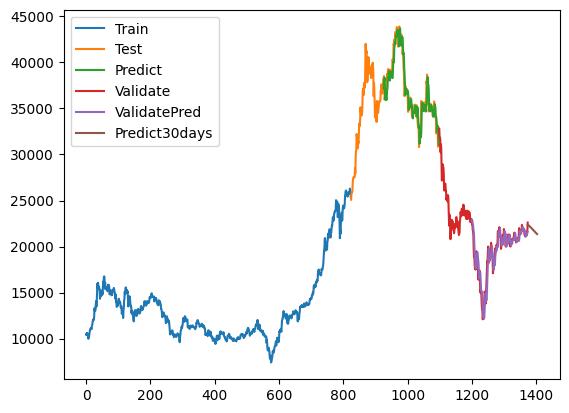

In [221]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()